In [ ]:
# Import Stuff
# !pip install timm
import os
import torch
import random
import IPython
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import torchvision.models as models

from sklearn import svm
from IPython.display import display
import torchvision.transforms as transforms
from scipy.stats import describe, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

#from google.colab import drive # Add this if you are using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CWT(nn.Module):
    def __init__(
        self,
        wavelet_width,
        fs,
        lower_freq,
        upper_freq,
        n_scales,
        size_factor=1.0,
        border_crop=0,
        stride=1
    ):
        super().__init__()

        self.initial_wavelet_width = wavelet_width
        self.fs = fs
        self.lower_freq = lower_freq
        self.upper_freq = upper_freq
        self.size_factor = size_factor
        self.n_scales = n_scales
        self.wavelet_width = wavelet_width
        self.border_crop = border_crop
        self.stride = stride
        wavelet_bank_real, wavelet_bank_imag = self._build_wavelet_kernel()
        self.wavelet_bank_real = nn.Parameter(wavelet_bank_real, requires_grad=False)
        self.wavelet_bank_imag = nn.Parameter(wavelet_bank_imag, requires_grad=False)

        self.kernel_size = self.wavelet_bank_real.size(3)

    def _build_wavelet_kernel(self):
        s_0 = 1 / self.upper_freq
        s_n = 1 / self.lower_freq

        base = np.power(s_n / s_0, 1 / (self.n_scales - 1))
        scales = s_0 * np.power(base, np.arange(self.n_scales))

        frequencies = 1 / scales
        truncation_size = scales.max() * np.sqrt(4.5 * self.initial_wavelet_width) * self.fs
        one_side = int(self.size_factor * truncation_size)
        kernel_size = 2 * one_side + 1

        k_array = np.arange(kernel_size, dtype=np.float32) - one_side
        t_array = k_array / self.fs

        wavelet_bank_real = []
        wavelet_bank_imag = []

        for scale in scales:
            norm_constant = np.sqrt(np.pi * self.wavelet_width) * scale * self.fs / 2.0
            scaled_t = t_array / scale
            exp_term = np.exp(-(scaled_t ** 2) / self.wavelet_width)
            kernel_base = exp_term / norm_constant
            kernel_real = kernel_base * np.cos(2 * np.pi * scaled_t)
            kernel_imag = kernel_base * np.sin(2 * np.pi * scaled_t)
            wavelet_bank_real.append(kernel_real)
            wavelet_bank_imag.append(kernel_imag)

        wavelet_bank_real = np.stack(wavelet_bank_real, axis=0)
        wavelet_bank_imag = np.stack(wavelet_bank_imag, axis=0)

        wavelet_bank_real = torch.from_numpy(wavelet_bank_real).unsqueeze(1).unsqueeze(2)
        wavelet_bank_imag = torch.from_numpy(wavelet_bank_imag).unsqueeze(1).unsqueeze(2)
        return wavelet_bank_real, wavelet_bank_imag

    def forward(self, x):
        border_crop = self.border_crop // self.stride
        start = border_crop
        end = (-border_crop) if border_crop > 0 else None

        # x [n_batch, n_channels, time_len]
        out_reals = []
        out_imags = []

        in_width = x.size(2)
        out_width = int(np.ceil(in_width / self.stride))
        pad_along_width = np.max((out_width - 1) * self.stride + self.kernel_size - in_width, 0)
        padding = pad_along_width // 2 + 1

        for i in range(18):
            # [n_batch, 1, 1, time_len]
            x_ = x[:, i, :].unsqueeze(1).unsqueeze(2)
            out_real = nn.functional.conv2d(x_, self.wavelet_bank_real, stride=(1, self.stride), padding=(0, padding))
            out_imag = nn.functional.conv2d(x_, self.wavelet_bank_imag, stride=(1, self.stride), padding=(0, padding))
            out_real = out_real.transpose(2, 1)
            out_imag = out_imag.transpose(2, 1)
            out_reals.append(out_real)
            out_imags.append(out_imag)

        out_real = torch.cat(out_reals, axis=1)
        out_imag = torch.cat(out_imags, axis=1)

        out_real = out_real[:, :, :, start:end]
        out_imag = out_imag[:, :, :, start:end]

        scalograms = torch.sqrt(out_real ** 2 + out_imag ** 2)
        return scalograms

## config

In [ ]:
class CFG:
    # Use your own dir if you are using google colab
    BASE_DIR  = "/content/drive/MyDrive/Colab_Notebooks/Machine_learning_for_medical_applications/Final_proj/hms-harmful-brain-activity-classification"
    SAVE_DIR  = "/content/drive/MyDrive/Colab_Notebooks/Machine_learning_for_medical_applications/Final_proj/hms-harmful-brain-activity-classification/numpy"

    # Init dic that need to convert class to num
    class_lst       = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    class_label_dic = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
    label_class_dic = {0: 'Seizure', 1: 'LPD', 2: 'GPD', 3: 'LRDA', 4: 'GRDA', 5: 'Other'}

    # sample rate & frequency
    # The reason I use num_sample here, is you could use different chunk to train
    # Here i give you is the default = sample_freq_eeg * data_duration_eeg
    # but from my perspective data_duration_eeg better < 50
    sample_freq_eeg   = 200
    data_duration_eeg = 50
    num_sample_eeg    = sample_freq_eeg * data_duration_eeg

    sample_freq_spec  = 1/2
    data_duration_spec = 600
    num_sample_spec    = int(sample_freq_spec * data_duration_spec)

    # You could also choose to use different features for egg, there are 20 features in total
    # The one i give you is 8
    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]

    # data type
    egg_dtype  = "float32"
    spec_dtype = "float32"

    # seed
    seed = 42

    # batch size
    BATCH_SIZE = 20

    # device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Init a CWT
    MyCWT = CWT(wavelet_width=7, fs=200, lower_freq=0.5, upper_freq=40, n_scales=40, border_crop=1, stride=16)

## Load Data

In [ ]:
# import datas from csv file into pandas.core.fram.DataFrame data type
# you probably only need to chance the base_dir if you using different dir
print("Importing data from csv file ......")
df      = pd.read_csv(os.path.join(CFG.BASE_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(CFG.BASE_DIR, "test.csv"))
print("Finish Importing.\n")

# If you would like to save files, i already created two folders
os.makedirs(os.path.join(CFG.BASE_DIR, 'train_spectrograms'), exist_ok=True)
os.makedirs(os.path.join(CFG.BASE_DIR, 'test_spectrograms'),  exist_ok=True)

Importing data from csv file ......
Finish Importing.



## Data preprocessing

In [ ]:
# Get EGG & spectrograms for each row, for both train and test
df['eeg_path']       = CFG.BASE_DIR + '/train_eegs/'         + df['eeg_id'].astype(str)         + '.parquet'
df['spec_path']      = CFG.BASE_DIR + '/train_spectrograms/' + df['spectrogram_id'].astype(str) + '.parquet'
df_test['eeg_path']  = CFG.BASE_DIR + '/test_eegs/'          + df['eeg_id'].astype(str)         + '.parquet'
df_test['spec_path'] = CFG.BASE_DIR + '/test_spectrograms/'  + df['spectrogram_id'].astype(str) + '.parquet'

# Create a new column that has the numerical value of label
df['label'] = df['expert_consensus'].map(CFG.class_label_dic)

### display dataframe for your interest
display(df.head())
display(df_test.head())

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path
0,853520,3911565283,6885,/content/drive/MyDrive/Colab_Notebooks/Machine...,/content/drive/MyDrive/Colab_Notebooks/Machine...


The number of training data: 106800
The number of test data:     1 



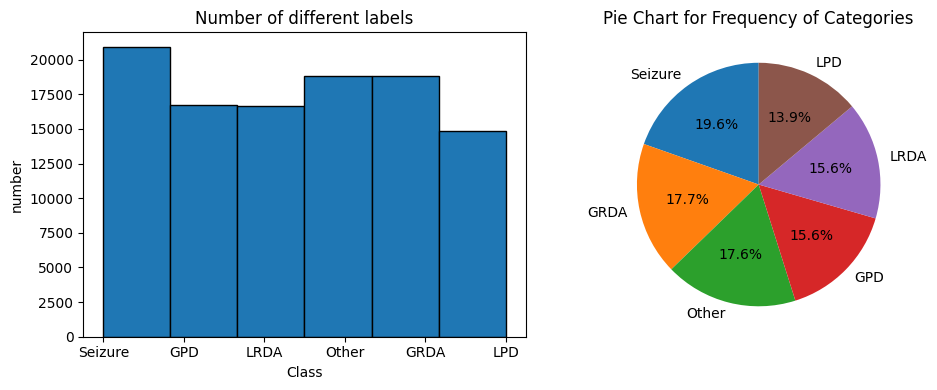

In [ ]:
# Get some info
print("The number of training data: {}".format(df.shape[0]))
print("The number of test data:     {} \n".format(len(df_test)))

# Plot the histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['expert_consensus'], bins=len(CFG.class_lst), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('number')
plt.title('Number of different labels')

# Plot the pie plot
plt.subplot(1, 2, 2)
value_counts = df['expert_consensus'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Frequency of Categories')
plt.tight_layout()
plt.show()

### Split the data into training and validation

In [ ]:
# Splite the training data into training and validation data
# While tryiing to maintain the expert consensus balanced
# AFTER SPLITE: the folder number is assign to 0 to 9 (10 fold case)
n_splits   = 10
skf        = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)
df['fold'] = -1

for fold, (_, val_index) in enumerate(skf.split(df.index, df['expert_consensus'])):
    df.loc[df.index[val_index], 'fold'] = fold

val_index   = [1]
test_index  = [2]
train_index = [3,4,5,6,7,8,9]

train_df = df[df['fold'].isin(train_index)]
val_df   = df[df['fold'].isin(val_index)]
test_df  = df[df['fold'].isin(test_index)]

print(" The training data number is {}.\n The validation data number is {}.\n The testing data number is {}.".format(train_df.shape[0],
                                                                                                                    test_df.shape[0],
                                                                                                                    val_df.shape[0]))

 The training data number is 74760.
 The validation data number is 10680.
 The testing data number is 10680.


#### Since my original dataset is too large because each iteration taking so long to trian on my computer, I choose to only use 10 percent of the data

In subset.
 The training data number is 7476.
 The validation data number is 1068.
 The testing data number is 1068.


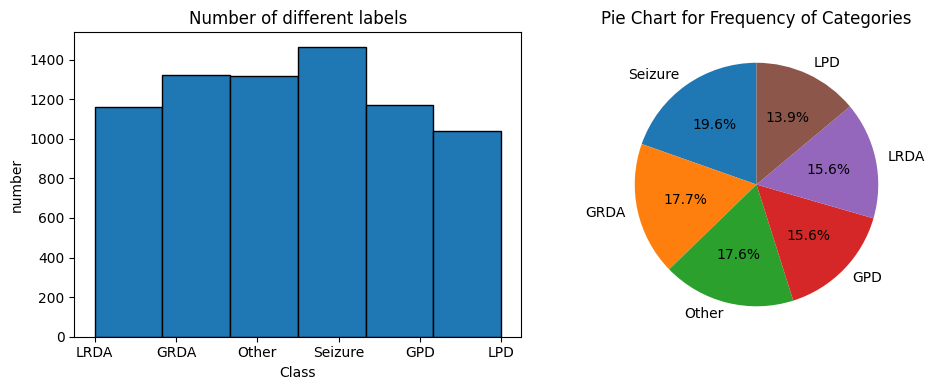

In [ ]:
df_subset         = test_df.copy(deep=True)
df_subset['fold'] = -1

for fold, (_, val_index) in enumerate(skf.split(df_subset.index, df_subset['expert_consensus'])):
    df_subset.loc[df_subset.index[val_index], 'fold'] = fold

val_index_subset   = [1]
test_index_subset  = [2]
train_index_subset = [3,4,5,6,7,8,9]

train_df_subset = df_subset[df_subset['fold'].isin(train_index_subset)]
val_df_subset   = df_subset[df_subset['fold'].isin(val_index_subset)]
test_df_subset  = df_subset[df_subset['fold'].isin(test_index_subset)]

print("In subset.\n The training data number is {}.\n The validation data number is {}.\n The testing data number is {}.".format(train_df_subset.shape[0],
                                                                                                                                 test_df_subset.shape[0],
                                                                                                                                 val_df_subset.shape[0]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_df_subset['expert_consensus'], bins=len(CFG.class_lst), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('number')
plt.title('Number of different labels')

# Plot the pie plot
plt.subplot(1, 2, 2)
value_counts = train_df_subset['expert_consensus'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Frequency of Categories')
plt.tight_layout()
plt.show()

### Define my dataset

### since the electrod position is Here, I choose to do some to the raw EEG data
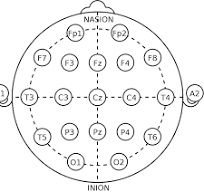!

### Since the data is provided in this way
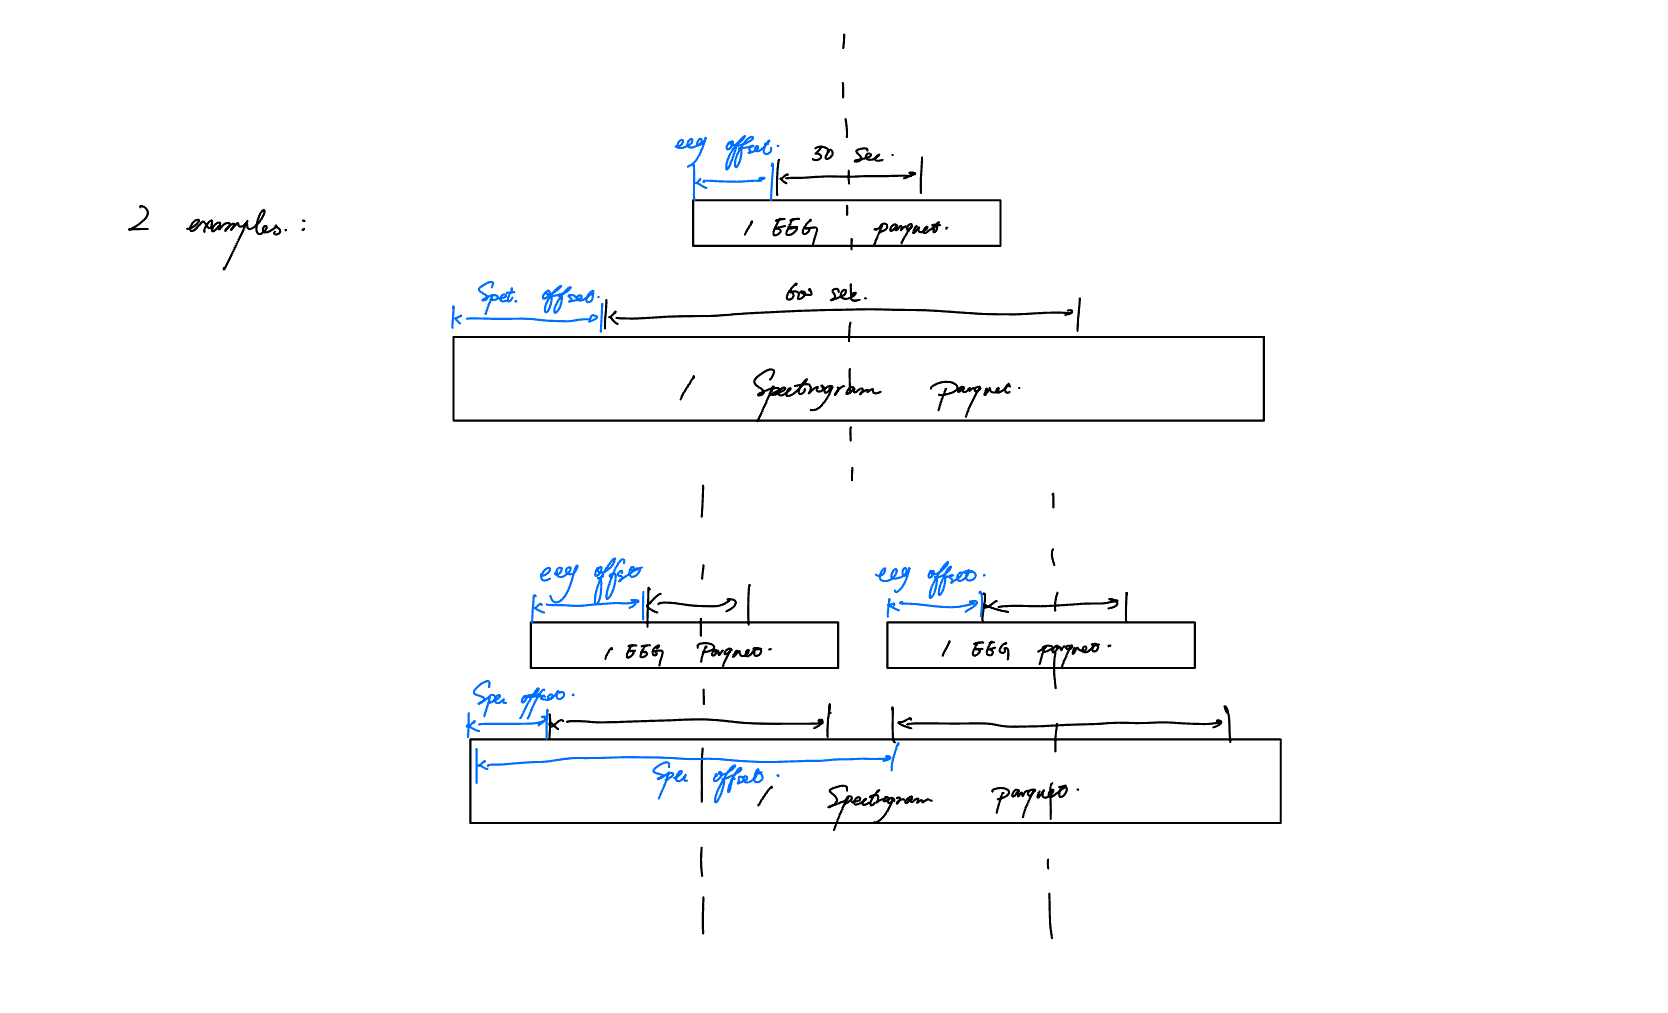![dat_alloc.png](attachment:dat_alloc.png)

For EEG data, we have option to use 50 second, 10 second, or 30 second. However, from my test, 50 second works the best.

In [ ]:
def parquet_to_eeg(eeg_path, offset):
    # In this function i simply modify the data by get rid of nan and set the dtype
    # the reason I use such a easy and simple function is becasuse it simply just load the parquet
    # I left pure and modification in the transform function
    # MORE job need to be done!
    eeg   = pd.read_parquet(eeg_path, columns=CFG.eeg_features)
    start = int(offset * CFG.sample_freq_eeg)
    end   = int(start + CFG.num_sample_eeg)
    egg   = eeg.iloc[start: end].fillna(0).values.astype(CFG.egg_dtype)
    return egg.T

In [ ]:
def parquet_to_eeg_dif(eeg_path, offset):
    # In this function I used the difference between connected node
    temp_eeg   = pd.read_parquet(eeg_path)
    start      = int(offset * CFG.sample_freq_eeg)
    end        = int(start + CFG.num_sample_eeg)
    temp_eeg   = temp_eeg.iloc[start: end].fillna(0).astype(CFG.egg_dtype)

    var1  = (temp_eeg['Fp1'] - temp_eeg['F7']).values
    var2  = (temp_eeg['F7']  - temp_eeg['T3']).values
    var3  = (temp_eeg['T3']  - temp_eeg['T5']).values
    var4  = (temp_eeg['T5']  - temp_eeg['O1']).values
    var5  = (temp_eeg['Fp1'] - temp_eeg['F3']).values
    var6  = (temp_eeg['F3']  - temp_eeg['C3']).values
    var7  = (temp_eeg['C3']  - temp_eeg['P3']).values
    var8  = (temp_eeg['P3']  - temp_eeg['O1']).values
    var9  = (temp_eeg['Fp2'] - temp_eeg['F8']).values
    var10 = (temp_eeg['F8']  - temp_eeg['T4']).values
    var11 = (temp_eeg['T4']  - temp_eeg['T6']).values
    var12 = (temp_eeg['T6']  - temp_eeg['O2']).values
    var13 = (temp_eeg['Fp2'] - temp_eeg['F4']).values
    var14 = (temp_eeg['F4']  - temp_eeg['C4']).values
    var15 = (temp_eeg['C4']  - temp_eeg['P4']).values
    var16 = (temp_eeg['P4']  - temp_eeg['O2']).values
    var17 = (temp_eeg['Fz']  - temp_eeg['Cz']).values
    var18 = (temp_eeg['Cz']  - temp_eeg['Pz']).values

    var = np.vstack([var1, var2, var3, var4, var5, var6, var7, var8, var9, var10,
                     var11, var12, var13, var14, var15, var16, var17, var18])

    return var

In [ ]:
def parquet_to_spec(spec_path, offset):
    # HERE, you can also load specific range of column by adding the second input
    spec  = pd.read_parquet(spec_path)
    start = int(np.floor(offset * CFG.sample_freq_spec))
    end   = start + CFG.num_sample_spec
    spec  = spec.iloc[start: end].fillna(0).values.astype(CFG.spec_dtype)
    return spec.T

### Also, I would like to do Continuous Wavelet Transform (CWT)
* CWT is a transform that breaks a signal into a spectrum of wavelets. Wavelets are functions that are localized in both time and frequency.

* discrete wavelet are for something like denoising and compression of signal and images

Reason:
* Why not use Fourier transformation because it gives global average over entire signal, if you interested in the information that happens a short time of interview, it might not work for FT. And the Wavelet Transform is good at extract localized and temporal information



Reference and intuition:
* Short Explain: https://www.google.com/search?q=what+is+Wavelet+Transform+youtube&sca_esv=b353dd35a34d02f9&rlz=1C1ONGR_enUS1104US1104&sxsrf=ACQVn08CAwIXf18vjCwMZSRcwBKqIZI3Ww%3A1713662541744&ei=TWokZt3fLPmq5NoPyrG9kAI&ved=0ahUKEwidusK4ktKFAxV5FVkFHcpYDyIQ4dUDCBE&uact=5&oq=what+is+Wavelet+Transform+youtube&gs_lp=Egxnd3Mtd2l6LXNlcnAiIXdoYXQgaXMgV2F2ZWxldCBUcmFuc2Zvcm0geW91dHViZTIEECMYJ0jRBVD9AVj9AXABeAGQAQCYAVGgAVGqAQExuAEDyAEA-AEBmAICoAJWwgIKEAAYsAMY1gQYR5gDAOIDBRIBMSBAiAYBkAYIkgcBMqAHpwI&sclient=gws-wiz-serp#kpvalbx=_UGokZuKxAa2v5NoP_8iYqAE_36

* intuition is from https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275356#1529639 and https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/492560

* CWT Code from CWT is from https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275356#1529639


BTW: before the CWT, the data shape is (18, 10_000), and after CWT, the data shape is (3, 40, 625). Hence, in order to use it on NN, need to reshape it into (512, 512) basically a 2-d square array

In [ ]:
def reshape_x(x):
    # I assume the size of x should look like [batch_size, 18, 10000]
    # after calling CWT, the size should be like [50, 18, 40, 625]
    # after concatenate with second dim the size should be like [50, 720, 625]
    x    = CFG.MyCWT(x)
    var0 =  x[:,0,:,:]
    var1  = x[:,1,:,:]
    var2  = x[:,2,:,:]
    var3  = x[:,3,:,:]
    var4  = x[:,4,:,:]
    var5  = x[:,5,:,:]
    var6  = x[:,6,:,:]
    var7  = x[:,7,:,:]
    var8  = x[:,8,:,:]
    var9  = x[:,9,:,:]
    var10 = x[:,10,:,:]
    var11 = x[:,11,:,:]
    var12 = x[:,12,:,:]
    var13 = x[:,13,:,:]
    var14 = x[:,14,:,:]
    var15 = x[:,15,:,:]
    var16 = x[:,16,:,:]
    var17 = x[:,17,:,:]

    var =  torch.cat([var0, var1, var2, var3, var4, var5, var6, var7, var8, var9, var10,
                         var11, var12, var13, var14, var15, var16, var17], dim=1)

    return var.unsqueeze(1)

In [ ]:
# define my dataset
class MyDataset(Dataset):
    def __init__(self, dataframe, transform_egg=None, transform_spec=None,
                 transform_lab=None, transform_vote=None,
                 dif=True, only_EEG=True, normalize_vote=True, smooth=True):
        self.dataframe      = dataframe
        self.transform_egg  = transform_egg
        self.transform_spec = transform_spec
        self.transform_lab  = transform_lab
        self.transform_vote = transform_vote
        self.dif            = dif
        self.only_EEG       = only_EEG
        self.normalize_vote = normalize_vote
        self.smooth         = smooth

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        df          = self.dataframe.iloc[idx]
        eeg_path    = df["eeg_path"]
        spec_path   = df["spec_path"]
        eeg_offset  = df["eeg_label_offset_seconds"]
        spec_offset = df["spectrogram_label_offset_seconds"]

        vote        = df[['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote', 'other_vote']].values.astype("int")
        label       = df['label']

        if self.dif:
            eeg = parquet_to_eeg_dif(eeg_path, eeg_offset)
        else:
            eeg = parquet_to_eeg(eeg_path, eeg_offset)

        if not self.only_EEG:
            spec = parquet_to_spec(spec_path, spec_offset)

        # Label smoothing：Add offset of 0.05 to each vote before normalizatio
        if self.normalize_vote:
            if self.smooth:
                vote = vote.astype(np.float64)
                vote += (np.ones(vote.shape[0]) * 0.05)
                vote = vote / vote.sum()

        if self.transform_egg:
            egg = self.transform_egg(eeg)[0]
        if self.transform_spec and not self.only_EEG:
            spec = self.transform_spec(spec)[0]
        if self.transform_lab:
            label = self.transform_lab(label)[0]
        if self.transform_vote:
            vote = self.transform_vote(vote)[0]

        if not self.only_EEG:
            return egg, spec, label, vote
        else:
            return egg, label, vote


In [ ]:
# define the dataloader
# YOU could add more transformer, actaully i think that is a good start point to investigate
transform = transforms.Compose([transforms.ToTensor()])

train_dataset       = MyDataset(train_df, transform_egg=transform)
test_dataset        = MyDataset(test_df,  transform_egg=transform)
validation_dataset  = MyDataset(val_df,   transform_egg=transform)

# Define the dataloader
train_dataloader      = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
test_dataloader       = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)

# This gives you a idea of what does the data look like
for x, z, k in train_dataloader:
    print("EGG  shape:  {}".format(x.shape))
    print("Label shape: {}".format(z.shape))
    print("Vote shape:  {}".format(k.shape))
    break

EGG  shape:  torch.Size([20, 18, 10000])
Label shape: torch.Size([20])
Vote shape:  torch.Size([20, 6])


In [ ]:
# also for subset
train_dataset_subset       = MyDataset(train_df_subset, transform_egg=transform)
test_dataset_subset        = MyDataset(test_df_subset,  transform_egg=transform)
validation_dataset_subset  = MyDataset(val_df_subset,   transform_egg=transform)

# Define the dataloader
train_dataloader_subset = DataLoader(train_dataset_subset, batch_size=CFG.BATCH_SIZE, shuffle=True)
test_dataloader_subset  = DataLoader(test_dataset_subset, batch_size=CFG.BATCH_SIZE, shuffle=True)

# This gives you a idea of what does the data look like
for x, z, k in train_dataloader_subset:
    print("EGG  shape:  {}".format(x.shape))
    print("Label shape: {}".format(z.shape))
    print("Vote shape:  {}".format(k.shape))
    break

EGG  shape:  torch.Size([20, 18, 10000])
Label shape: torch.Size([20])
Vote shape:  torch.Size([20, 6])


### Basically, at this point, my task is turn into some image processsing problem.
Here is few image looking examples.

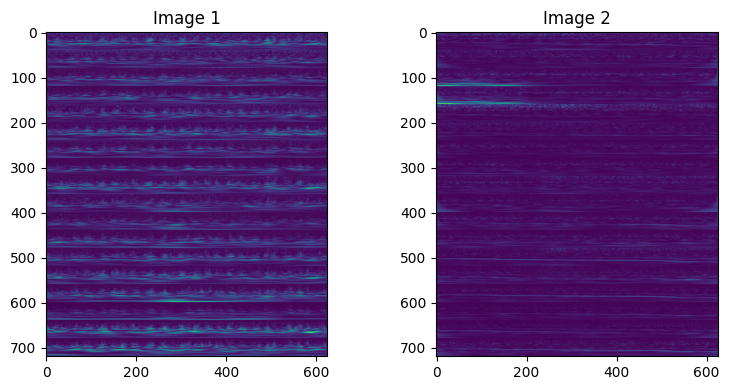

In [ ]:
# Here is some example about how the image look like
temp_x   = reshape_x(x)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

axs[0].imshow(temp_x[0][0])
axs[0].set_title('Image 1')

axs[1].imshow(temp_x[1][0])
axs[1].set_title('Image 2')

plt.tight_layout()
plt.show()

### Defining model, train function, evaluation function

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # Convolutional layers
        self.cov1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU())
        self.cov2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=3, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.cov3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Linear layers for feature condensation
        # the last relu layer is to avoid my predicter to predict negative values.
        self.linear = nn.Sequential(
            nn.Linear(32 * 40 * 35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6),
            nn.ReLU())

        # softmax layer
        self.softmax = nn.Softmax(dim=1)

        # Dropout (optional)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU activation
        x = self.cov1(x)
        x = self.cov2(x)
        x = self.cov3(x)
        x = self.maxpool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Linear
        x = self.linear(x)

        # softmax, noramlize x
        x = self.softmax(x)

        return x


In [ ]:
def Train_model(model,epochs,optmizer,criterion,train_loader, display=True):
    """
    model: input model
    epochs: training epoch number
    optimizer: the optimizer
    criterion: the criterion for the loss
    """

    # YOUR CODES GO HERE
    total_step = len(train_loader)
    total_loss = 0
    loss_list  = []
    acc_list   = []

    for epoch in range(epochs):
        for i, (X, L, V) in enumerate(train_loader):
            X    = reshape_x(X)
            X, L, V = X.to(CFG.device), L.to(CFG.device), V.to(CFG.device)

            ##Setting the all the gradients to zero before backprobagation
            model.train()
            optmizer.zero_grad()

            # Forward pass
            # The forward process computes the loss of each sample in this minibatch
            outputs = model(X)
            predict = torch.max(outputs, 1)[1]

            # Caculate loss
            # the first input the probability of each class, the second is the vote
            # x (but not y) should be logprobs, say the doc.
            loss     = criterion(torch.log_softmax(outputs, dim=1), V)

            # calculate acc
            correct_predictions = torch.eq(predict, L).sum().item()
            total_examples      = len(L)
            accuracy            = correct_predictions / total_examples

            # Backward pass
            loss.backward()

            # use the optimizer to update the parameters
            optmizer.step()

            # Computing the total loss of the steps taken so far
            #Hint: the loss for each step is the average loss of the minibatch processed in that step
            total_loss = loss

            # Below, an epoch corresponds to one pass through all the samples.
            # Each training step corresponds to a parameter update using
            # a gradient computed on a minibatch of 100 samples
            if display:
                if (i + 1) % 5 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy:{:.4f}'
                          .format(epoch + 1, epochs, i + 1, total_step, total_loss / CFG.BATCH_SIZE, accuracy))

            total_loss = 0

        loss_list.append(total_loss)
        acc_list.append(accuracy)

    return loss_list, acc_list


In [ ]:
# Please plot the confusion matrix and print out the accuracy on the testing set

# YOUR CODES GO HERE
def test_CNN(model, test_loader, criterion):
    with torch.no_grad():
            pred      = np.array([])
            label     = np.array([])
            loss_arr  = np.array([])

            correct   = 0
            total     = 0

            model.train()
            for X, L, V in test_loader:
                X    = reshape_x(X)
                X, L, V = X.to(CFG.device), L.to(CFG.device), V.to(CFG.device)

                # feed test data into trained model
                outputs  = model(X)
                predict  = torch.max(outputs, 1)[1]
                loss     = criterion(torch.log_softmax(outputs, dim=1), V)
                avg_loss = loss.item() / CFG.BATCH_SIZE

                label    = np.concatenate((label, L.cpu().numpy()))
                pred     = np.concatenate((pred, predict.cpu().numpy()))
                loss_arr = np.append(loss_arr, avg_loss)

                correct_predictions = torch.eq(predict, L).sum().item()
                total_examples      = len(L)

                correct += correct_predictions
                total   += total_examples
                print("Iteration Accuracy: ", correct_predictions/total_examples)


    # calculate accuracy and loss
    return_accuracy = accuracy_score(label, pred)
    return_loss     = loss_arr.mean()
    return return_accuracy, return_loss, pred, label

In [ ]:
def print_test_info(CNN_accuracy, CNN_loss, CNN_label, CNN_pred, confusion=True):
    print("The accuracy on the testing dataset: {}".format(CNN_accuracy))
    print("The loss     on the testing dataset: {}".format(CNN_loss))
    if confusion:
        cm = confusion_matrix(CNN_label, CNN_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.unique(CNN_label), yticklabels=np.unique(CNN_label))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

#### For loss function, I choose to use KLDivLoss
KLDivLoss (Kullback-Leibler Divergence Loss) is a loss function used in machine learning and deep learning, typically to measure the dissimilarity between two probability distributions

* Due to the characteristic of the dataset, It seems like taking forever to train even one epoch on 10 percent of the entire dataset. Hence, I train my model and the pretrained model on another python script (please let me know if you are interested.)

* I have tested on different optimizer like Adam, SGD .... And the answer is Adam is the best one for my task.

* I also tested on different Learning rate, for one epoch lr = 0.001 work the best. Finally, I choose to schedule a dynamic learning rate, for epoch 1 and 2, I choose lr=0.001 and for epoch 3 I choose lr = 0.0001

As you can see the result does not went well for my own model. Hence, I am planning to use other pretrained model. And I trained my model with another script, if you have question, please let me know. Here, I will just load my trained model.


In [ ]:
# init the criterion
criterion = nn.KLDivLoss(reduction='batchmean').to(CFG.device)

# load the model
MyModel_epoch_1 =  torch.load('/content/drive/MyDrive/Colab_Notebooks/Machine_learning_for_medical_applications/Final_proj/pretrianed_r50_epoch_time_1.pth')
MyModel_epoch_2 =  torch.load('/content/drive/MyDrive/Colab_Notebooks/Machine_learning_for_medical_applications/Final_proj/pretrianed_r50_epoch_time_2.pth')

Here is the evaluation on the pretrained model (which i trained on the dataset in another script). The number in the below column is the accuracy. Remember the batch size is 20, so dont be suprise if the accuracy is end with 0 or 5.

# I would like to make some clarification:
You might wondering, why I am doing validation on test subset data, am I wrong? The answer is No, the variable named "validation_dataloader" is the true test dataset. Why I am making this confuse, becasue when I init a subset for test, and train, at first, since it takes too long to train, I just accidently picked test_dataloader to splite, which cause the variable "test_dataloader" became the true validation dataloader, and the test_dataloader is actaully the subset of the validation dataset. Hence, what I do is test my model on a subset of the true validation data!

## Epoch 1 result:

Iteration Accuracy:  0.8
Iteration Accuracy:  0.55
Iteration Accuracy:  0.55
Iteration Accuracy:  0.5
Iteration Accuracy:  0.65
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.7
Iteration Accuracy:  0.9
Iteration Accuracy:  0.55
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.7
Iteration Accuracy:  0.85
Iteration Accuracy:  0.85
Iteration Accuracy:  0.8
Iteration Accuracy:  0.55
Iteration Accuracy:  0.85
Iteration Accuracy:  0.65
Iteration Accuracy:  0.8
Iteration Accuracy:  0.6
Iteration Accuracy:  0.6
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.6
Iteration Accuracy:  0.8
Iteration Accuracy:  0.65
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.55
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.75
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.65
Iteration Accuracy:  0.75
Iteratio

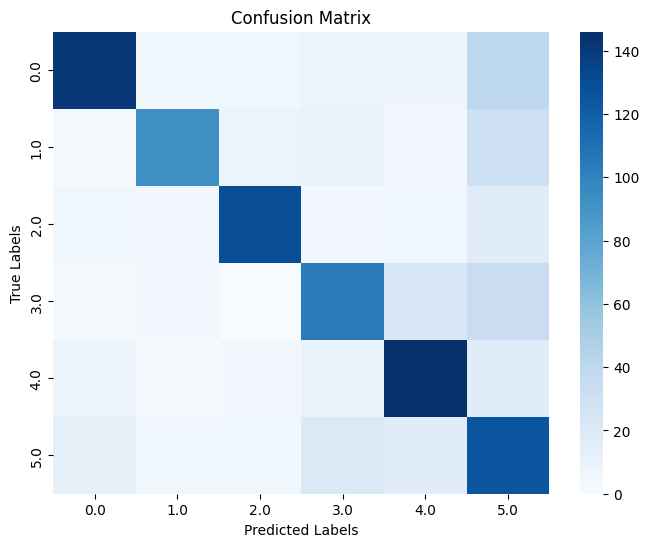

In [ ]:
CNN_accuracy_1, CNN_loss_1, CNN_pred_1, CNN_label_1 = test_CNN(MyModel_epoch_1, test_dataloader_subset, criterion)
print_test_info(CNN_accuracy_1, CNN_loss_1, CNN_label_1, CNN_pred_1, confusion=True)

## Epoch 2 result:

Iteration Accuracy:  0.6
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.65
Iteration Accuracy:  0.75
Iteration Accuracy:  1.0
Iteration Accuracy:  0.8
Iteration Accuracy:  0.9
Iteration Accuracy:  0.6
Iteration Accuracy:  0.6
Iteration Accuracy:  0.65
Iteration Accuracy:  0.7
Iteration Accuracy:  0.35
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.7
Iteration Accuracy:  0.6
Iteration Accuracy:  0.7
Iteration Accuracy:  0.6
Iteration Accuracy:  0.6
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.75
Iteration Accuracy:  0.9
Iteration Accuracy:  0.55
Iteration Accuracy:  0.85
Iteration Accuracy:  0.65
Iteration Accuracy:  0.85
Iteration Accuracy:  0.85
Iteration Accuracy:  0.55
Iteration Accuracy:  0.7
Iteration Accuracy:  0.65
Iteration Accuracy:  0.65
Iteration Accuracy:  0.7
Iteration Accuracy:  0.9
Iteration Accuracy:  0.6
Iteration Accuracy:  0.75
Iteration Accuracy:  0.8
Iteration Accuracy:  0.6
Iteration

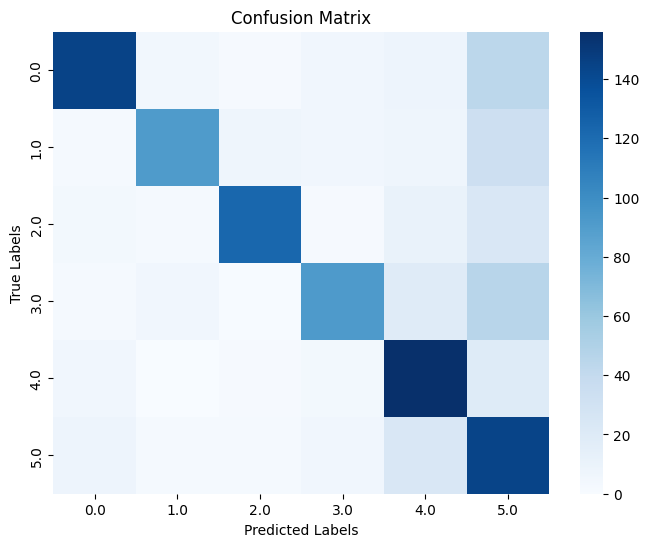

In [ ]:
CNN_accuracy_2, CNN_loss_2, CNN_pred_2, CNN_label_2 = test_CNN(MyModel_epoch_2, test_dataloader_subset, criterion)
print_test_info(CNN_accuracy_2, CNN_loss_2, CNN_label_2, CNN_pred_2, confusion=True)

## Epoch 3 result:

Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.75
Iteration Accuracy:  0.95
Iteration Accuracy:  0.75
Iteration Accuracy:  0.9
Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.75
Iteration Accuracy:  0.8
Iteration Accuracy:  0.85
Iteration Accuracy:  0.75
Iteration Accuracy:  0.85
Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.85
Iteration Accuracy:  0.65
Iteration Accuracy:  0.75
Iteration Accuracy:  0.75
Iteration Accuracy:  0.55
Iteration Accuracy:  0.6
Iteration Accuracy:  0.9
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.9
Iteration Accuracy:  0.7
Iteration Accuracy:  0.75
Iteration Accuracy:  0.7
Iteration Accuracy:  0.8
Iteration Accuracy:  0.85
Iteration Accuracy:  0.8
Iteration Accuracy:  0.7
Iteration Accuracy:  0.6
Iteration Accuracy:  0.7
Iteration Accuracy:  0.75
Iteration Accuracy:  0.95
Iteration Accuracy:  0.8
Iteration Accuracy:  0.85
Iteratio

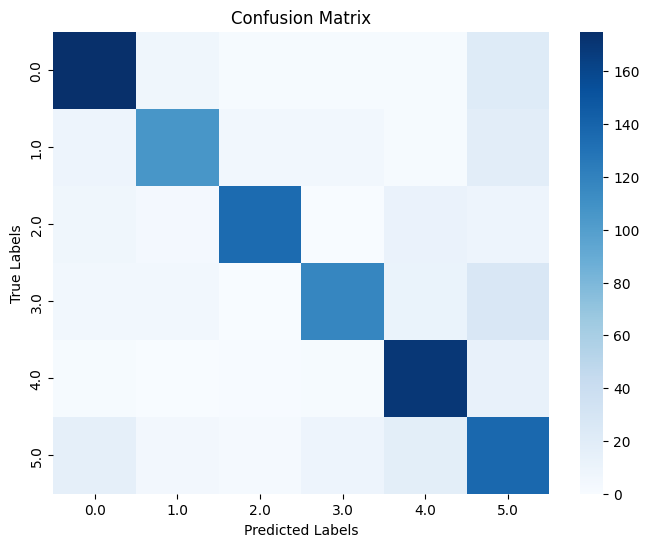

In [ ]:
MyModel_epoch_3 =  torch.load('/content/drive/MyDrive/Colab_Notebooks/Machine_learning_for_medical_applications/Final_proj/pretrianed_r50_epoch_3.pth')
CNN_accuracy_3, CNN_loss_3, CNN_pred_3, CNN_label_3 = test_CNN(MyModel_epoch_3, test_dataloader_subset, criterion)
print_test_info(CNN_accuracy_3, CNN_loss_3, CNN_label_3, CNN_pred_3, confusion=True)

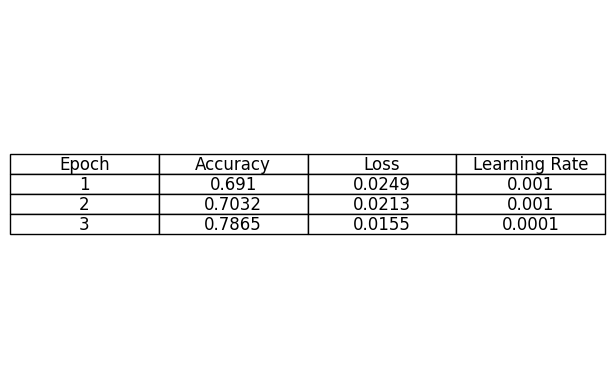

In [ ]:
epochs   = np.array([1, 2, 3])
accuracy = np.round(np.array([CNN_accuracy_1, CNN_accuracy_2, CNN_accuracy_3]),4)
loss     = np.round(np.array([CNN_loss_1, CNN_loss_2, CNN_loss_3]), 4)
lr       = np.array([0.001, 0.001, 0.0001])

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')

table_data = list(zip(epochs, accuracy, loss, lr))
column_headers = ["Epoch", "Accuracy", "Loss", "Learning Rate"]

table = ax.table(cellText=table_data, colLabels=column_headers, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()